# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

state vector dim = 4
n_actions = 2


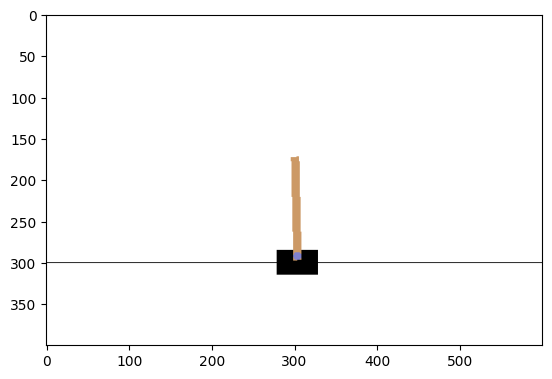

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
# X = 4*2 - env_size*n_actions
# y = n_actions
agent.partial_fit(X=[env.reset()] * n_actions, y=range(n_actions), classes=range(n_actions))
agent.n_features_in_, agent.classes_

(4, array([0, 1]))

In [4]:
agent.predict_proba([[1.5, 2.6, -3.7, 4.0]])[0].shape

(2,)

In [5]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    state = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([state])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        action = np.random.choice([0, 1], p=probs)

        new_state, reward, done, info = env.step(action)

        # record sessions like you did before
        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if done:
            break
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.04288026  0.03652366  0.00762639  0.00309744]
 [-0.04214979 -0.15870683  0.00768834  0.2981768 ]
 [-0.04532392 -0.35393754  0.01365187  0.59327453]
 [-0.05240268 -0.5492479   0.02551736  0.8902263 ]
 [-0.06338763 -0.35448128  0.04332189  0.6056728 ]]
actions: [0, 0, 0, 1, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    # find top performing policies in terms of reward by percentile
    reward_threshold = np.percentile(rewards_batch, q=percentile)

    elite_states = []
    elite_actions = []

    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)

    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 195.120, threshold=200.000


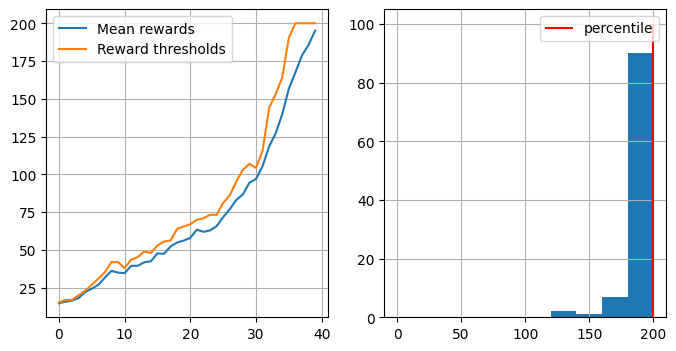

 39%|███▉      | 39/100 [01:33<02:25,  2.39s/it]

You Win! You may stop training now via KeyboardInterrupt.


In [9]:
import tqdm
n_sessions = 100
percentile = 70
log = []

for i in tqdm.tqdm(range(100)):
    # generate new sessions
    sessions = [ generate_session(env, agent) for _ in range(n_sessions) ]

    # states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Results

In [52]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```

### n_sessions

Уменьшение `n_sessions` до 100 слабо изменило процесс "обучения". Обучение прошло менее стабильно (графики растут менее плавно), разброс mean после пика стал больше:

![Taxi CEM 100 50](assets/CEM_100_50.png)

Рассмотренный на лекции вариант (для визуального сравнения):

![Taxi CEM 250 50](assets/CEM_250_50.png)

Увеличение `n_sessions` до 500 слабо изменило процесс "обучения". Обучение прошло чуток быстрее и стабильнее (графики растут быстрее и плавнее), разброс mean после пика стал несколько менее ярковыраженным, максимальное значение mean немного выросло, "кусок распределения" в районе `reward=800` стал намного меньше:

![Taxi CEM 500 50](assets/CEM_500_50.png)

В целом изменение `n_sessions` для нас как бы меняет размер выборки, и изменения, которые видно на приведённых выше графиках, отражают базовую идею "больше данных - лучше учится, меньше данных - хуже учится", ничего экстраординарного.

Кроме того, в процессе обучения однажды значение mean перевалило через ноль и достигло 0.102. Так что технически задача дотюнить алгоритм до положительного скора выполнена :)

### percentile

Уменьшение значения `percentile` до 25% привело к замедлению обучения (графики растут медленнее), но одновременно с этим сильно замедлило деградацию решения после достижения пика (это не совсем заметно по графику, но mean в этом сценарии тоже начал падать, просто небыстро и несильно), "кусок распределения" в районе `reward=800` стал намного меньше:

![Taxi CEM 250 25](assets/CEM_250_25.png)

Рассмотренный на лекции вариант (для визуального сравнения):

![Taxi CEM 250 50](assets/CEM_250_50.png)

Увеличение значения `percentile` до 80% привело к тому, что появилась ярковыраженная деградация решения после достижения пика mean:

![Taxi CEM 250 80](assets/CEM_250_80.png)

Как было указано преподавателем в ноутбуке `crossentropy_method.ipynb`, деградация сама по себе отчасти объясняется тем, что реализованный нами "жадный" выбор элит приводит к тому, что, однаждый не обучившись на каком-то энвайроменте, алгоритм уже не сможет на нём затем обучиться. Однако если для значения `percentile` 50% мы обучаемся на 50% выборки (что концептуально не особо "жадно"), то при увеличении `percentile` до 80% жадность алгоритма усиливается и играет с нами злую шутку. После того, как модель переобучается на малое количество элитных состояний, оказывается, что она начинает работать на остальной выборке хуже, чем совершенно не обученная модель - на лицо типичное переобучение.

### n_sessions + percentile

Если совместить два наилучших подхода из описанных выше - много сессий и маленький перцентиль, то можно получить алгоритм, стабильно переваливающий mean через ноль, решая задачу 1.2:

![Taxi CEM 250 80](assets/CEM_500_25.png)

P.S.: Не сложно заметить, что я не привожу код, которым получил эти графики. Это такой же код, который был на лекции, потому и не привожу. Ну, почти такой же, у меня сравнительно хитрый сетап (Windows + WSL2 + XServer), так что немного довести напильником визуализацию пришлось, и конечно поковыряться с версиями зависимостей, но семантически всё точно такое же.

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

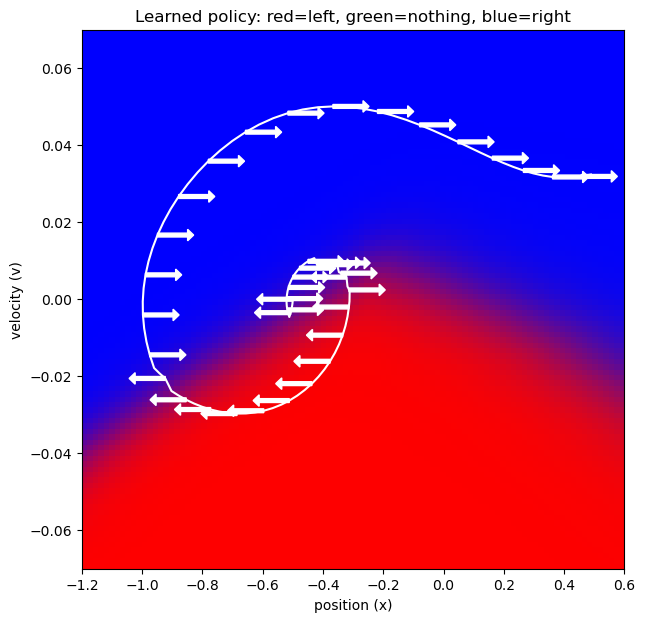

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_mountain_car)

### Код решения

sessions generation time, s.: 0.8379707336425781
-253.0 -171.75 30.810509570599447
training time, s.: 0.015955448150634766
mean reward = -171.750, threshold=-151.200


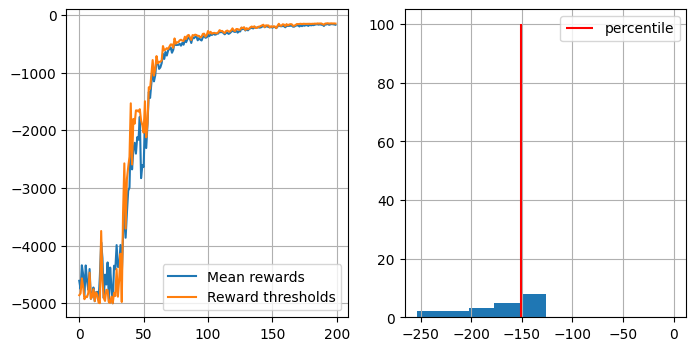

100%|██████████| 200/200 [17:01<00:00,  5.11s/it]


In [10]:

import os


# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"


import gym
import numpy as np
from sklearn.neural_network import MLPClassifier
import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import copy
from joblib import Parallel, delayed, parallel_backend


env = gym.make("MountainCar-v0").env  # create scene by name
print(f'example of environment: {env.reset()}')  # initialize starting state, env is of shape (2,) - coordinate and velocity
n_actions = env.action_space.n  # 3 - left, right, nothing
print(f'number of actions for agent: {n_actions}')

agent = MLPClassifier(
    hidden_layer_sizes=(30, 30),
    activation='tanh',
)

n_samples = n_actions  # needs to be same for successful initialization of classes in partial_fit()
# initialize agent to the dimension of state space and number of actions
agent.partial_fit(
    X=[env.reset()] * n_samples,  # X = 2*3 - env_size*n_actions
    y=range(n_samples),  # y = n_actions
    classes=range(n_actions)  # [0, 1, 2]
)
print(agent.n_features_in_, agent.classes_)  # observation space, actions <=> 2 [0 1]


def generate_session(env, agent, t_max=40000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    # print('tick')
    local_tick = time.time()
    states, actions = [], []
    total_reward = 0

    env_local = gym.make("MountainCar-v0").env  # create scene by name
    env = env_local
    # agent_local = copy.copy(agent)
    # agent = agent_local

    state = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([state])[0]
        # if t % 1000 == 0:
        #     print(f'probs: {probs}')

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        action = np.random.choice([0, 1, 2], p=probs)

        new_state, reward, done, info = env.step(action)

        # record sessions like you did before
        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if done:
            # print('done')
            break
    # ~2s for 10K
    # print(f'time of session with {t_max} ticks: {time.time() - local_tick}')
    return states, actions, total_reward


# states, actions, total_reward = generate_session(env, agent, t_max=20000)
# print(total_reward)
# raise KeyboardInterrupt


def select_elites(states_batch, actions_batch, rewards_batch, percentile, MAX_TICKS):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states, elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    print(np.min(rewards_batch), np.mean(rewards_batch), np.std(rewards_batch))

    # find top performing policies in terms of reward by percentile
    if np.mean(rewards_batch) == -MAX_TICKS and np.std(rewards_batch) == 0:
        # only time-outed sessions, use all
        reward_threshold = -MAX_TICKS-1
    elif np.min(rewards_batch) == -MAX_TICKS and np.std(rewards_batch) != 0:
        # cut only time-outed or by percentile, choosing bigger cut

        # reward_threshold = -MAX_TICKS + 1
        values, counts = np.unique(rewards_batch, return_counts=True)
        number_timed_out = dict(zip(values, counts))[-MAX_TICKS]
        percent_timed_out = number_timed_out / len(rewards_batch) * 100

        if percent_timed_out > percentile:
            reward_threshold = np.percentile(rewards_batch, q=percent_timed_out)
        else:
            reward_threshold = np.percentile(rewards_batch, q=percentile)

    elif np.min(rewards_batch) > -MAX_TICKS and np.std(rewards_batch) != 0:
        # business as usual
        reward_threshold = np.percentile(rewards_batch, q=percentile)
    else:
        raise(f'Some weird rewards_batch; min: {np.min(rewards_batch)}, max: {np.max(rewards_batch)}, mean: {np.mean(rewards_batch)}, std: {np.std(rewards_batch)}')
    # if hard_limit and np.max(rewards_batch) > -MAX_TICKS:
    #     reward_threshold = hard_limit

    elite_states = []
    elite_actions = []

    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)
    
    # if len(elite_states) == 0 and reward_threshold == -MAX_TICKS
    # can be empty if all sessions timed out

    return elite_states, elite_actions, reward_threshold


def show_progress(rewards_batch, log, percentile, reward_range, threshold_):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    threshold = threshold_
    log.append([mean_reward, threshold])

    # clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([threshold],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


n_sessions = 20
percentile = 60
log = []
MAX_TICKS = 5000

# with open('agent_best_200iter_20sess_60perc_5000tick_169mean.pkl', 'rb') as f:
    # agent = pickle.load(f)

for i in tqdm.tqdm(range(200)):
    # generate new sessions
    tick = time.time()
    # sessions = [ generate_session(env, agent, t_max=MAX_TICKS) for _ in range(n_sessions) ]
    with parallel_backend('multiprocessing'):
        sessions = Parallel(n_jobs=4)(
            delayed(generate_session)(env=None, agent=agent, t_max=MAX_TICKS) for _ in range(n_sessions)
        )
    clear_output(True)
    print(f'sessions generation time, s.: {time.time()-tick}')

    # states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # print(np.mean(rewards_batch), np.std(rewards_batch))
    # # break
    # if np.min(rewards_batch) == -MAX_TICKS:
    #     hard_limit=-MAX_TICKS
    # else:
        # hard_limit = None

    # tick = time.time()
    elite_states, elite_actions, threshold = select_elites(
        states_batch, actions_batch, rewards_batch, percentile=percentile, MAX_TICKS=MAX_TICKS
    )
    # print(f'elite selection time, s.: {time.time()-tick}')

    # print(len(elite_states), elite_states[0].shape)

    tick = time.time()
    agent.partial_fit(elite_states, elite_actions)
    print(f'training time, s.: {time.time()-tick}')

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 0], threshold_=threshold)

    # if np.mean(rewards_batch) > 190:
    #     print("You Win! You may stop training now via KeyboardInterrupt.")
    #     break

По итогу я получил mean в ~-127 двумя тренировками:
* с нуля обучал с параметрами `iterations = 200, sessions = 20, percentile = 60, MAX_TICKS=5000`
* затем дообучал с параметрами `iterations = 400, sessions = 50, percentile = 60, MAX_TICKS=5000`

Графики обоих этапов:


![Машинка 1](assets/agent_best_200iter_20sess_60perc_5000tick_169mean.png)
![Машинка 2](assets/agent_best_200iter_20sess_60perc_5000tick_169mean_plus_400iter_50sess_60perc_5000tick_127_mean.png)

Опишу, некоторые аспекты решения, почему делал так, как делал.

* `MAX_TICKS`. Я специально сделал его значение меньше предлагаемого при постановке задачи, исходя из двух соображений. Во-первых, так как целевое значение `reward` - минимум -150, то логично ожидать, что в процессе обучения агент достаточно быстро дойдёт до значения `reward` где-то около -1000, и затем обучение замедлится. То есть ожидается, что достаточно быстро после начала обучения конкретное значение `MAX_TICKS` потеряет важность. В то же время уменьшение `MAX_TICKS` позволило сетке на первых эпохах "тайм-аутиться" быстрее и быстрее переходить к следующей эпохе. Я думаю, что по итогу такое значение `MAX_TICKS` сделало суммарный процесс обучения быстрее, не повлияв негативно на качество.
* `select_elites`. Вместо стандартного перцентильного подхода я сделал немного более хитрую вещь. Дело в том, что на первых эпохах обучения очень многие сессии "тайм-аутятся", и на вход `select_elites` приходит большая доля сессий, у которых `reward = -MAX_TICKS`. Таких сессий может быть много,и потенциально больше, чем `percentile`. Поэтому я выбираю перцентиль как максимум между честно посчитанным перцентилем и долей "тайм-аут" сессий. Это позволяет гарантировать, что на первых эпохах алгортм будет меньше "тормозить" об "тайм-аутнувшиеся" сессии.
* `joblib`. Конкретно на моём локальном сетапе наилучшим образом сработала мультипроцессная модель с 4 воркерами. 4 воркера потому что 4 ядра в компьютере, мультипроцессинг потому что... не знаю, почему :) У меня он стабильно работает в 2.5-3 раза быстрее, чем мультипоточность, на что грешить не знаю, на сериализацию, на GIL, ещё на что-то...

<!-- Почему-то при генерации сессий на 5000 шагов в среднем меньше сессий умирает по тайм-ауту... -->

In [9]:
import pickle

# with open('agent_best_200iter_20sess_60perc_5000tick_169mean_plus_400iter_20sess_60perc_5000tick_127_mean.pkl', 'wb') as f:
#     pickle.dump(agent, f)


### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.